<table class="tfo-notebook-buttons" align="left">
<td style="border: none;">
<a target="blank" href="https://colab.research.google.com/github/Hari31416/Portfolio/blob/main/ML\Disaster_Tweets\modeling.ipynb?hl=en"><img src="https://colab.research.google.com/img/colab_favicon_256px.png" width="28" height="28"/>Run on Google Colab</a></td>
<td style="border: none;">
<a target="blank" href="https://github.com/Hari31416/Portfolio/blob/main/ML\Disaster_Tweets\modeling.ipynb"><img src="https://cdn.icon-icons.com/icons2/2368/PNG/512/github_logo_icon_143772.png" width="28" height="28"/>View on Github</a></td>
<td style="border: none;">
</table>


<h1 id="Contents">Contents<a href="#Contents"></a></h1>
        <ol>
        <li><a class="" href="#Imports">Imports</a></li>
<li><a class="" href="#Loading-Data">Loading Data</a></li>
<ol><li><a class="" href="#Downloading-Data">Downloading Data</a></li>
<li><a class="" href="#Reading-and-Making-Data-Ready">Reading and Making Data Ready</a></li>
</ol><li><a class="" href="#Modeling">Modeling</a></li>
<ol><li><a class="" href="#Some-Functions">Some Functions</a></li>
<li><a class="" href="#Base-Model-(Naive-Bayes)">Base Model (Naive Bayes)</a></li>
<li><a class="" href="#Deep-Learning-Models">Deep Learning Models</a></li>
<ol><li><a class="" href="#Text-Vectorization-and-Embedding">Text Vectorization and Embedding</a></li>
<li><a class="" href="#Creating-Datasets">Creating Datasets</a></li>
<li><a class="" href="#Model-1">Model 1</a></li>
<li><a class="" href="#Transfer-Learning">Transfer Learning</a></li>
<ol><li><a class="" href="#Conv-Model">Conv Model</a></li>
<li><a class="" href="#LSTM-Model">LSTM Model</a></li>
<li><a class="" href="#Bidirectional-LSTM">Bidirectional LSTM</a></li>
<li><a class="" href="#GRU-Unit">GRU Unit</a></li>
<li><a class="" href="#Final-Model">Final Model</a></li>
</ol><li><a class="" href="#Creating-a-Multivariate-Model">Creating a Multivariate Model</a></li>
<ol><li><a class="" href='#Using-"USE"-For-both-the-text-and-keyword'>Using "USE" For both the text and keyword</a></li>
<li><a class="" href="#Using-Character-Level-Encoding-for-keyword">Using Character Level Encoding for keyword</a></li>
</ol>

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Loading Data

## Downloading Data

Run this cell on Google Colab to get the cleaned data.

In [3]:
!wget https://raw.githubusercontent.com/Hari31416/Portfolio/main/ML/Disaster_Tweets/data/train_clean.csv
!wget https://raw.githubusercontent.com/Hari31416/Portfolio/main/ML/Disaster_Tweets/data/test_clean.csv

--2022-06-18 04:03:17--  https://raw.githubusercontent.com/Hari31416/Portfolio/main/ML/Disaster_Tweets/data/train_clean.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 687237 (671K) [text/plain]
Saving to: ‘train_clean.csv’

train_clean.csv     100%[===================>] 671.13K  --.-KB/s    in 0.04s   

2022-06-18 04:03:17 (15.8 MB/s) - ‘train_clean.csv’ saved [687237/687237]

--2022-06-18 04:03:18--  https://raw.githubusercontent.com/Hari31416/Portfolio/main/ML/Disaster_Tweets/data/test_clean.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respons

## Reading and Making Data Ready

In [4]:
train = pd.read_csv(r'train_clean.csv')
test = pd.read_csv(r'test_clean.csv')

In [5]:
id = test["id"]

In [6]:
train_text = train["text"]
test_text = test["text"]
target = train["target"]

We'll create the train test split.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_text, target, test_size=0.1, random_state=42)

# Modeling

## Some Functions

Let's write some functions to help us.

In [7]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [32]:
import datetime
def create_tensorboard_callback(experiment_name, dir_name="mnist"):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

def create_early_stopping_callback(monitor = 'val_accuracy', patience=5):
  early_stopping_callback = tf.keras.callbacks.EarlyStopping(
      monitor=monitor, patience=patience
  )
  return early_stopping_callback

def create_model_checkpoint(experiment_name, dir_name="tweets",
                            save_freq='epoch', monitor = "val_accuracy"):

  checkpoint_dir = dir_name + "/" + experiment_name
  checkpoint_callback = ModelCheckpoint(
    checkpoint_dir, monitor=monitor, verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq=save_freq,
  )
  print(f"Saving model checkpoint to: {checkpoint_dir}")
  return checkpoint_callback

## Base Model (Naive Bayes)

Before begining our modeling, we'll create a base model. This will ve a Naive Bayes model.

In [ ]:
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("nb", MultinomialNB())
])
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('nb', MultinomialNB())])

In [ ]:
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.8982481751824818, 0.7913385826771654)

The base model is giving an accuracy of 79%.

In [ ]:
base_model_performance = calculate_results(y_test, pipe.predict(X_test))
base_model_performance

{'accuracy': 79.13385826771653,
 'f1': 0.7865535576835297,
 'precision': 0.7974211556888723,
 'recall': 0.7913385826771654}

Now that we have our base model, we can start experimenting with other models.

## Deep Learning Models

Before we can use deep learning models, we need to make sure that our data is in the right format. We have to vectorize our data and make an embedding.

### Text Vectorization and Embedding

In [ ]:
MAX_VOCAB_SIZE = 10000
MAX_LENGTH = 20
tokenizer = tfl.TextVectorization(max_tokens=MAX_VOCAB_SIZE, output_sequence_length=MAX_LENGTH, name="tokenizer")
tokenizer.adapt(train_text)

In [ ]:
vocab = tokenizer.get_vocabulary()
vocab[:10], vocab[-10:]

(['', '[UNK]', 'like', 'e', 'amp', 'im', 'a', 'fire', 't', 'get'],
 ['nailreal',
  'nagaski',
  'naemolgo',
  'nades',
  'naayf',
  'naaa',
  'na',
  'n36',
  'n15b',
  'myths'])

In [ ]:
embedd = tfl.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_length=MAX_LENGTH, name="embedd_1")

### Creating Datasets

This will result in faster training.

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Model 1

We'll start with a small model.

In [ ]:
input = tfl.Input(shape=(1,), dtype="string", name="input1")
x = tokenizer(input)
x = embedd(x)
x = tfl.Flatten(name="flatten1")(x) 
x = tfl.Dense(128, activation="relu", name="dense1")(x)
output = tfl.Dense(1, activation="sigmoid")(x)
model_1 = Model(inputs=input, outputs=output)
model_1.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["accuracy"])
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input1 (InputLayer)         [(None, 1)]               0         
                                                                 
 tokenizer (TextVectorizatio  (None, 20)               0         
 n)                                                              
                                                                 
 embedd_1 (Embedding)        (None, 20, 128)           1280000   
                                                                 
 flatten1 (Flatten)          (None, 2560)              0         
                                                                 
 dense1 (Dense)              (None, 128)               327808    
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                           

In [ ]:
history_1 = model_1.fit(train_dataset,
                        epochs=10,
                        steps_per_epoch = len(train_dataset),
                        validation_data = test_dataset,
                        validation_steps = len(test_dataset),
                        )

Epoch 1/10
215/215 [==============================] - 1s 5ms/step - loss: 0.0749 - accuracy: 0.9728 - val_loss: 0.7744 - val_accuracy: 0.7612
Epoch 2/10
215/215 [==============================] - 1s 4ms/step - loss: 0.0299 - accuracy: 0.9851 - val_loss: 0.9334 - val_accuracy: 0.7572
Epoch 3/10
215/215 [==============================] - 1s 4ms/step - loss: 0.0269 - accuracy: 0.9857 - val_loss: 1.0584 - val_accuracy: 0.7559
Epoch 4/10
215/215 [==============================] - 1s 4ms/step - loss: 0.0258 - accuracy: 0.9855 - val_loss: 1.1475 - val_accuracy: 0.7572
Epoch 5/10
215/215 [==============================] - 1s 4ms/step - loss: 0.0253 - accuracy: 0.9858 - val_loss: 1.2092 - val_accuracy: 0.7572
Epoch 6/10
215/215 [==============================] - 1s 4ms/step - loss: 0.0249 - accuracy: 0.9861 - val_loss: 1.2625 - val_accuracy: 0.7598
Epoch 7/10
215/215 [==============================] - 1s 4ms/step - loss: 0.0248 - accuracy: 0.9864 - val_loss: 1.3058 - val_accuracy: 0.7493
Epoch 

The model is quickly overfitting.

### Transfer Learning

Using transfer learning can significantly improve the performance of our model. This is what we'll do.

#### Conv Model

Let's use the USE encoder from tensorflow hub. Let's use a `Conv1D` layer with this encoder.

In [ ]:
import tensorflow_hub as hub
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [ ]:
# Create model using the Sequential API
model_2 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  tfl.Reshape((64, 8), input_shape=(512,)),

  tfl.Conv1D(32, 5, padding="valid"),
  tfl.Conv1D(64, 5, padding="valid"),
   tfl.MaxPool1D(2),
  tfl.Dropout(0.7),
  tfl.BatchNormalization(),

  tfl.Conv1D(128, 5, padding="valid"),
  tfl.Conv1D(256, 5, padding="valid"),
   tfl.MaxPool1D(2),
  tfl.Dropout(0.7),
  tfl.BatchNormalization(),

  tfl.Conv1D(256, 3, padding="valid"),
  tfl.Conv1D(512, 3, padding="valid"),
  tfl.Dropout(0.8),
  tfl.BatchNormalization(),
  tfl.Dense(128, activation="relu"),
  tfl.Dropout(0.8),
  tfl.BatchNormalization(),
    tfl.GlobalAveragePooling1D(),
  tfl.Dense(1, activation="sigmoid")
], name="model_2_USE")

# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.summary()

Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 reshape_9 (Reshape)         (None, 64, 8)             0         
                                                                 
 conv1d_37 (Conv1D)          (None, 60, 32)            1312      
                                                                 
 conv1d_38 (Conv1D)          (None, 56, 64)            10304     
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 28, 64)           0         
 g1D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 28, 64)            0         
                                                       

In [ ]:
history_2 = model_2.fit(train_dataset,
                        epochs=10,
                        steps_per_epoch = len(train_dataset),
                        validation_data = test_dataset,
                        validation_steps = len(test_dataset),
                        )

Epoch 1/10
215/215 [==============================] - 8s 20ms/step - loss: 0.6544 - accuracy: 0.6232 - val_loss: 0.6550 - val_accuracy: 0.5682
Epoch 2/10
215/215 [==============================] - 4s 17ms/step - loss: 0.5841 - accuracy: 0.7066 - val_loss: 0.5830 - val_accuracy: 0.6719
Epoch 3/10
215/215 [==============================] - 4s 18ms/step - loss: 0.5414 - accuracy: 0.7387 - val_loss: 0.4887 - val_accuracy: 0.7835
Epoch 4/10
215/215 [==============================] - 4s 17ms/step - loss: 0.5248 - accuracy: 0.7472 - val_loss: 0.4579 - val_accuracy: 0.8005
Epoch 5/10
215/215 [==============================] - 4s 18ms/step - loss: 0.5028 - accuracy: 0.7655 - val_loss: 0.4517 - val_accuracy: 0.8084
Epoch 6/10
215/215 [==============================] - 4s 18ms/step - loss: 0.5049 - accuracy: 0.7679 - val_loss: 0.4459 - val_accuracy: 0.8071
Epoch 7/10
215/215 [==============================] - 4s 18ms/step - loss: 0.4883 - accuracy: 0.7790 - val_loss: 0.4428 - val_accuracy: 0.8136

Looks promising. Let's fit for some more epochs with callbacks.

In [ ]:
history_3 = model_2.fit(train_dataset,
                        epochs=50,
                        steps_per_epoch = len(train_dataset),
                        validation_data = test_dataset,
                        validation_steps = len(test_dataset),
                        callbacks = [create_model_checkpoint("conv")]
                        )

Saving model checkpoint to: tweets/conv
Epoch 1/50
215/215 [==============================] - ETA: 0s - loss: 0.4741 - accuracy: 0.7857
Epoch 1: val_accuracy improved from -inf to 0.78346, saving model to tweets/conv


INFO:tensorflow:Assets written to: tweets/conv/assets


INFO:tensorflow:Assets written to: tweets/conv/assets


215/215 [==============================] - 16s 77ms/step - loss: 0.4741 - accuracy: 0.7857 - val_loss: 0.4932 - val_accuracy: 0.7835
Epoch 2/50
212/215 [============================>.] - ETA: 0s - loss: 0.4728 - accuracy: 0.7883
Epoch 2: val_accuracy improved from 0.78346 to 0.81365, saving model to tweets/conv


INFO:tensorflow:Assets written to: tweets/conv/assets


INFO:tensorflow:Assets written to: tweets/conv/assets


215/215 [==============================] - 15s 68ms/step - loss: 0.4724 - accuracy: 0.7886 - val_loss: 0.4404 - val_accuracy: 0.8136
Epoch 3/50
214/215 [============================>.] - ETA: 0s - loss: 0.4659 - accuracy: 0.7912
Epoch 3: val_accuracy did not improve from 0.81365
215/215 [==============================] - 4s 17ms/step - loss: 0.4661 - accuracy: 0.7911 - val_loss: 0.4350 - val_accuracy: 0.8136
Epoch 4/50
215/215 [==============================] - ETA: 0s - loss: 0.4605 - accuracy: 0.7920
Epoch 4: val_accuracy improved from 0.81365 to 0.81890, saving model to tweets/conv


INFO:tensorflow:Assets written to: tweets/conv/assets


INFO:tensorflow:Assets written to: tweets/conv/assets


215/215 [==============================] - 15s 69ms/step - loss: 0.4605 - accuracy: 0.7920 - val_loss: 0.4296 - val_accuracy: 0.8189
Epoch 5/50
214/215 [============================>.] - ETA: 0s - loss: 0.4644 - accuracy: 0.7937
Epoch 5: val_accuracy did not improve from 0.81890
215/215 [==============================] - 4s 18ms/step - loss: 0.4645 - accuracy: 0.7936 - val_loss: 0.4364 - val_accuracy: 0.8058
Epoch 6/50
212/215 [============================>.] - ETA: 0s - loss: 0.4543 - accuracy: 0.7978
Epoch 6: val_accuracy did not improve from 0.81890
215/215 [==============================] - 4s 18ms/step - loss: 0.4542 - accuracy: 0.7977 - val_loss: 0.4348 - val_accuracy: 0.8163
Epoch 7/50
214/215 [============================>.] - ETA: 0s - loss: 0.4612 - accuracy: 0.7953
Epoch 7: val_accuracy did not improve from 0.81890
215/215 [==============================] - 6s 27ms/step - loss: 0.4613 - accuracy: 0.7952 - val_loss: 0.4444 - val_accuracy: 0.8071
Epoch 8/50
213/215 [==========

INFO:tensorflow:Assets written to: tweets/conv/assets


INFO:tensorflow:Assets written to: tweets/conv/assets


215/215 [==============================] - 20s 94ms/step - loss: 0.4429 - accuracy: 0.8044 - val_loss: 0.4344 - val_accuracy: 0.8255
Epoch 15/50
214/215 [============================>.] - ETA: 0s - loss: 0.4499 - accuracy: 0.8015
Epoch 15: val_accuracy did not improve from 0.82546
215/215 [==============================] - 5s 25ms/step - loss: 0.4501 - accuracy: 0.8015 - val_loss: 0.4330 - val_accuracy: 0.8084
Epoch 16/50
212/215 [============================>.] - ETA: 0s - loss: 0.4387 - accuracy: 0.8068
Epoch 16: val_accuracy did not improve from 0.82546
215/215 [==============================] - 6s 27ms/step - loss: 0.4394 - accuracy: 0.8061 - val_loss: 0.4387 - val_accuracy: 0.8058
Epoch 17/50
215/215 [==============================] - ETA: 0s - loss: 0.4411 - accuracy: 0.8053
Epoch 17: val_accuracy did not improve from 0.82546
215/215 [==============================] - 4s 18ms/step - loss: 0.4411 - accuracy: 0.8053 - val_loss: 0.4283 - val_accuracy: 0.8189
Epoch 18/50
212/215 [===

In [ ]:
best_model = tf.keras.models.load_model("tweets/conv")

In [ ]:
best_model.evaluate(test_dataset)

24/24 [==============================] - 1s 12ms/step - loss: 0.4344 - accuracy: 0.8255


[0.4343593716621399, 0.8254593014717102]

#### LSTM Model

In [ ]:
# Create model using the Sequential API
model_3 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  tfl.Reshape((64, 8), input_shape=(512,)),

  tfl.LSTM(32, return_sequences = True, activation="tanh"),
  tfl.LSTM(64, return_sequences = True , activation="tanh"),
  tfl.MaxPool1D(2),
  tfl.Dropout(0.6),
  tfl.BatchNormalization(),

   tfl.LSTM(128, return_sequences = True, activation="tanh"),
#   tfl.Dropout(0.6),

    tfl.GlobalAveragePooling1D(),
    # tfl.Dense(128, "relu"),
    # tfl.Dropout(0.7),
    #   tfl.BatchNormalization(),
    # tfl.Dense(256, "relu"),
    # tfl.Dropout(0.8),
  tfl.Dense(1, activation="sigmoid")
], name="model_3_USE")

# Compile model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

Model: "model_3_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 reshape_14 (Reshape)        (None, 64, 8)             0         
                                                                 
 lstm_9 (LSTM)               (None, 64, 32)            5248      
                                                                 
 lstm_10 (LSTM)              (None, 64, 64)            24832     
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 32, 64)           0         
 g1D)                                                            
                                                                 
 dropout_80 (Dropout)        (None, 32, 64)            0         
                                                       

In [ ]:
history_4 = model_3.fit(train_dataset,
                        epochs=10,
                        steps_per_epoch = len(train_dataset),
                        validation_data = test_dataset,
                        validation_steps = len(test_dataset),
                        # callbacks = [create_model_checkpoint("conv")]
                        )

Epoch 1/10
215/215 [==============================] - 12s 29ms/step - loss: 0.6447 - accuracy: 0.6307 - val_loss: 0.6750 - val_accuracy: 0.5656
Epoch 2/10
215/215 [==============================] - 5s 22ms/step - loss: 0.6219 - accuracy: 0.6565 - val_loss: 0.6599 - val_accuracy: 0.6640
Epoch 3/10
215/215 [==============================] - 5s 22ms/step - loss: 0.6152 - accuracy: 0.6682 - val_loss: 0.6813 - val_accuracy: 0.5486
Epoch 4/10
215/215 [==============================] - 5s 22ms/step - loss: 0.6077 - accuracy: 0.6731 - val_loss: 0.6163 - val_accuracy: 0.6627
Epoch 5/10
215/215 [==============================] - 5s 22ms/step - loss: 0.6029 - accuracy: 0.6800 - val_loss: 0.6162 - val_accuracy: 0.6745
Epoch 6/10
215/215 [==============================] - 5s 22ms/step - loss: 0.5943 - accuracy: 0.6872 - val_loss: 0.6030 - val_accuracy: 0.6929
Epoch 7/10
215/215 [==============================] - 5s 22ms/step - loss: 0.5871 - accuracy: 0.6959 - val_loss: 0.6034 - val_accuracy: 0.685

LSTM is not performing very well. Let's try birectional LSTM.

#### Bidirectional LSTM

In [ ]:
# Create model using the Sequential API
model_4 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  tfl.Reshape((64, 8), input_shape=(512,)),

  tfl.Bidirectional(tfl.LSTM(64, return_sequences = True)),
  tfl.Bidirectional(tfl.LSTM(128, return_sequences = True)),
#   tfl.Bidirectional(tfl.LSTM(256, return_sequences = True)),
#   tfl.MaxPool1D(2),
  tfl.Dropout(0.6),
#   tfl.BatchNormalization(),

   tfl.Bidirectional(tfl.LSTM(128, return_sequences = True)),
   tfl.Bidirectional(tfl.LSTM(256, return_sequences = True)),
  tfl.Dropout(0.6),

    tfl.GlobalAveragePooling1D(),
    # tfl.Dense(128, "relu"),
    # tfl.Dropout(0.5),
    # tfl.BatchNormalization(),
    # tfl.Dense(256, "relu"),
    # tfl.Dropout(0.5),

  tfl.Dense(1, activation="sigmoid")
], name="model_4_USE")

# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_4.summary()

Model: "model_4_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 reshape_29 (Reshape)        (None, 64, 8)             0         
                                                                 
 bidirectional_20 (Bidirecti  (None, 64, 128)          37376     
 onal)                                                           
                                                                 
 bidirectional_21 (Bidirecti  (None, 64, 256)          263168    
 onal)                                                           
                                                                 
 dropout_89 (Dropout)        (None, 64, 256)           0         
                                                                 
 bidirectional_22 (Bidirecti  (None, 64, 256)          

In [ ]:
history_5 = model_4.fit(train_dataset,
                        epochs=10,
                        steps_per_epoch = len(train_dataset),
                        validation_data = test_dataset,
                        validation_steps = len(test_dataset),
                        # callbacks = [create_model_checkpoint("conv")]
                        )

Epoch 1/10
215/215 [==============================] - 23s 59ms/step - loss: 0.6587 - accuracy: 0.6178 - val_loss: 0.6677 - val_accuracy: 0.6417
Epoch 2/10
215/215 [==============================] - 9s 42ms/step - loss: 0.6394 - accuracy: 0.6416 - val_loss: 0.6337 - val_accuracy: 0.6706
Epoch 3/10
215/215 [==============================] - 9s 41ms/step - loss: 0.6302 - accuracy: 0.6530 - val_loss: 0.6260 - val_accuracy: 0.6654
Epoch 4/10
215/215 [==============================] - 9s 41ms/step - loss: 0.6231 - accuracy: 0.6645 - val_loss: 0.6236 - val_accuracy: 0.6706
Epoch 5/10
215/215 [==============================] - 9s 41ms/step - loss: 0.6045 - accuracy: 0.6759 - val_loss: 0.6040 - val_accuracy: 0.6982
Epoch 6/10
215/215 [==============================] - 9s 41ms/step - loss: 0.6182 - accuracy: 0.6607 - val_loss: 0.6435 - val_accuracy: 0.6850
Epoch 7/10
215/215 [==============================] - 9s 42ms/step - loss: 0.6796 - accuracy: 0.5726 - val_loss: 0.6773 - val_accuracy: 0.572

Let's fit for some more epochs

In [ ]:
history_5 = model_4.fit(train_dataset,
                        epochs=50,
                        steps_per_epoch = len(train_dataset),
                        validation_data = test_dataset,
                        validation_steps = len(test_dataset),
                        callbacks = [create_model_checkpoint("bi_LSTM")]
                        )

Saving model checkpoint to: tweets/bi_LSTM
Epoch 1/50
215/215 [==============================] - ETA: 0s - loss: 0.5465 - accuracy: 0.7328
Epoch 1: val_accuracy improved from -inf to 0.74541, saving model to tweets/bi_LSTM


INFO:tensorflow:Assets written to: tweets/bi_LSTM/assets


INFO:tensorflow:Assets written to: tweets/bi_LSTM/assets


215/215 [==============================] - 61s 282ms/step - loss: 0.5465 - accuracy: 0.7328 - val_loss: 0.5433 - val_accuracy: 0.7454
Epoch 2/50
214/215 [============================>.] - ETA: 0s - loss: 0.5349 - accuracy: 0.7404
Epoch 2: val_accuracy did not improve from 0.74541
215/215 [==============================] - 9s 43ms/step - loss: 0.5350 - accuracy: 0.7403 - val_loss: 0.5352 - val_accuracy: 0.7388
Epoch 3/50
214/215 [============================>.] - ETA: 0s - loss: 0.5281 - accuracy: 0.7449
Epoch 3: val_accuracy improved from 0.74541 to 0.75591, saving model to tweets/bi_LSTM


INFO:tensorflow:Assets written to: tweets/bi_LSTM/assets


INFO:tensorflow:Assets written to: tweets/bi_LSTM/assets


215/215 [==============================] - 60s 280ms/step - loss: 0.5282 - accuracy: 0.7448 - val_loss: 0.5225 - val_accuracy: 0.7559
Epoch 4/50
214/215 [============================>.] - ETA: 0s - loss: 0.5234 - accuracy: 0.7484
Epoch 4: val_accuracy did not improve from 0.75591
215/215 [==============================] - 9s 42ms/step - loss: 0.5235 - accuracy: 0.7483 - val_loss: 0.5134 - val_accuracy: 0.7480
Epoch 5/50
214/215 [============================>.] - ETA: 0s - loss: 0.5183 - accuracy: 0.7560
Epoch 5: val_accuracy did not improve from 0.75591
215/215 [==============================] - 9s 42ms/step - loss: 0.5183 - accuracy: 0.7559 - val_loss: 0.5200 - val_accuracy: 0.7454
Epoch 6/50
214/215 [============================>.] - ETA: 0s - loss: 0.5573 - accuracy: 0.7180
Epoch 6: val_accuracy did not improve from 0.75591
215/215 [==============================] - 9s 41ms/step - loss: 0.5572 - accuracy: 0.7181 - val_loss: 0.5598 - val_accuracy: 0.7336
Epoch 7/50
215/215 [=========

INFO:tensorflow:Assets written to: tweets/bi_LSTM/assets


INFO:tensorflow:Assets written to: tweets/bi_LSTM/assets


215/215 [==============================] - 62s 291ms/step - loss: 0.5280 - accuracy: 0.7474 - val_loss: 0.5165 - val_accuracy: 0.7612
Epoch 9/50
215/215 [==============================] - ETA: 0s - loss: 0.5181 - accuracy: 0.7569
Epoch 9: val_accuracy improved from 0.76115 to 0.77034, saving model to tweets/bi_LSTM


INFO:tensorflow:Assets written to: tweets/bi_LSTM/assets


INFO:tensorflow:Assets written to: tweets/bi_LSTM/assets


215/215 [==============================] - 60s 278ms/step - loss: 0.5181 - accuracy: 0.7569 - val_loss: 0.5109 - val_accuracy: 0.7703
Epoch 10/50
215/215 [==============================] - ETA: 0s - loss: 0.5153 - accuracy: 0.7565
Epoch 10: val_accuracy did not improve from 0.77034
215/215 [==============================] - 9s 42ms/step - loss: 0.5153 - accuracy: 0.7565 - val_loss: 0.5056 - val_accuracy: 0.7612
Epoch 11/50
215/215 [==============================] - ETA: 0s - loss: 0.5077 - accuracy: 0.7601
Epoch 11: val_accuracy improved from 0.77034 to 0.77428, saving model to tweets/bi_LSTM


INFO:tensorflow:Assets written to: tweets/bi_LSTM/assets


INFO:tensorflow:Assets written to: tweets/bi_LSTM/assets


215/215 [==============================] - 60s 280ms/step - loss: 0.5077 - accuracy: 0.7601 - val_loss: 0.4977 - val_accuracy: 0.7743
Epoch 12/50
215/215 [==============================] - ETA: 0s - loss: 0.5015 - accuracy: 0.7653
Epoch 12: val_accuracy did not improve from 0.77428
215/215 [==============================] - 9s 42ms/step - loss: 0.5015 - accuracy: 0.7653 - val_loss: 0.5034 - val_accuracy: 0.7690
Epoch 13/50
214/215 [============================>.] - ETA: 0s - loss: 0.4988 - accuracy: 0.7694
Epoch 13: val_accuracy did not improve from 0.77428
215/215 [==============================] - 9s 41ms/step - loss: 0.4988 - accuracy: 0.7693 - val_loss: 0.4968 - val_accuracy: 0.7690
Epoch 14/50
215/215 [==============================] - ETA: 0s - loss: 0.5031 - accuracy: 0.7650
Epoch 14: val_accuracy did not improve from 0.77428
215/215 [==============================] - 9s 41ms/step - loss: 0.5031 - accuracy: 0.7650 - val_loss: 0.5018 - val_accuracy: 0.7690
Epoch 15/50
215/215 [==

INFO:tensorflow:Assets written to: tweets/bi_LSTM/assets


INFO:tensorflow:Assets written to: tweets/bi_LSTM/assets


215/215 [==============================] - 60s 279ms/step - loss: 0.4939 - accuracy: 0.7698 - val_loss: 0.4930 - val_accuracy: 0.7756
Epoch 16/50
215/215 [==============================] - ETA: 0s - loss: 0.4927 - accuracy: 0.7712
Epoch 16: val_accuracy did not improve from 0.77559
215/215 [==============================] - 9s 41ms/step - loss: 0.4927 - accuracy: 0.7712 - val_loss: 0.4924 - val_accuracy: 0.7664
Epoch 17/50
215/215 [==============================] - ETA: 0s - loss: 0.4884 - accuracy: 0.7764
Epoch 17: val_accuracy did not improve from 0.77559
215/215 [==============================] - 9s 42ms/step - loss: 0.4884 - accuracy: 0.7764 - val_loss: 0.4949 - val_accuracy: 0.7743
Epoch 18/50
214/215 [============================>.] - ETA: 0s - loss: 0.4837 - accuracy: 0.7795
Epoch 18: val_accuracy did not improve from 0.77559
215/215 [==============================] - 9s 41ms/step - loss: 0.4836 - accuracy: 0.7796 - val_loss: 0.4945 - val_accuracy: 0.7677
Epoch 19/50
215/215 [==

INFO:tensorflow:Assets written to: tweets/bi_LSTM/assets


INFO:tensorflow:Assets written to: tweets/bi_LSTM/assets


215/215 [==============================] - 60s 279ms/step - loss: 0.4923 - accuracy: 0.7734 - val_loss: 0.4996 - val_accuracy: 0.7769
Epoch 21/50
215/215 [==============================] - ETA: 0s - loss: 0.4797 - accuracy: 0.7787
Epoch 21: val_accuracy improved from 0.77690 to 0.78215, saving model to tweets/bi_LSTM


INFO:tensorflow:Assets written to: tweets/bi_LSTM/assets


INFO:tensorflow:Assets written to: tweets/bi_LSTM/assets


215/215 [==============================] - 60s 280ms/step - loss: 0.4797 - accuracy: 0.7787 - val_loss: 0.4861 - val_accuracy: 0.7822
Epoch 22/50
214/215 [============================>.] - ETA: 0s - loss: 0.4752 - accuracy: 0.7785
Epoch 22: val_accuracy did not improve from 0.78215
215/215 [==============================] - 9s 42ms/step - loss: 0.4752 - accuracy: 0.7785 - val_loss: 0.4945 - val_accuracy: 0.7690
Epoch 23/50
215/215 [==============================] - ETA: 0s - loss: 0.4753 - accuracy: 0.7829
Epoch 23: val_accuracy did not improve from 0.78215
215/215 [==============================] - 9s 41ms/step - loss: 0.4753 - accuracy: 0.7829 - val_loss: 0.4921 - val_accuracy: 0.7677
Epoch 24/50
215/215 [==============================] - ETA: 0s - loss: 0.4682 - accuracy: 0.7860
Epoch 24: val_accuracy improved from 0.78215 to 0.78346, saving model to tweets/bi_LSTM


INFO:tensorflow:Assets written to: tweets/bi_LSTM/assets


INFO:tensorflow:Assets written to: tweets/bi_LSTM/assets


215/215 [==============================] - 60s 281ms/step - loss: 0.4682 - accuracy: 0.7860 - val_loss: 0.4927 - val_accuracy: 0.7835
Epoch 25/50
215/215 [==============================] - ETA: 0s - loss: 0.4717 - accuracy: 0.7841
Epoch 25: val_accuracy did not improve from 0.78346
215/215 [==============================] - 10s 47ms/step - loss: 0.4717 - accuracy: 0.7841 - val_loss: 0.4798 - val_accuracy: 0.7808
Epoch 26/50
214/215 [============================>.] - ETA: 0s - loss: 0.4720 - accuracy: 0.7826
Epoch 26: val_accuracy did not improve from 0.78346
215/215 [==============================] - 9s 41ms/step - loss: 0.4719 - accuracy: 0.7826 - val_loss: 0.4911 - val_accuracy: 0.7782
Epoch 27/50
215/215 [==============================] - ETA: 0s - loss: 0.4674 - accuracy: 0.7883
Epoch 27: val_accuracy did not improve from 0.78346
215/215 [==============================] - 9s 42ms/step - loss: 0.4674 - accuracy: 0.7883 - val_loss: 0.4938 - val_accuracy: 0.7612
Epoch 28/50
214/215 [=

#### GRU Unit

In [ ]:
# Create model using the Sequential API
model_4 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  tfl.Reshape((32, 16), input_shape=(512,)),

  tfl.GRU(32, return_sequences = True),
  tfl.GRU(64, return_sequences = True),
  tfl.MaxPool1D(2),
  tfl.Dropout(0.8),
  tfl.BatchNormalization(),

   tfl.GRU(128, return_sequences = True),
   tfl.GRU(256, return_sequences = True),
   tfl.Dropout(0.8),

    tfl.GlobalAveragePooling1D(),
    # tfl.Dense(128, "relu"),
    # tfl.Dropout(0.7),
    # tfl.BatchNormalization(),
    # tfl.Dense(256, "relu"),
    # tfl.Dropout(0.8),
  tfl.Dense(1, activation="sigmoid")
], name="model_4_USE")

# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_4.summary()

Model: "model_4_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 reshape_26 (Reshape)        (None, 32, 16)            0         
                                                                 
 gru_16 (GRU)                (None, 32, 32)            4800      
                                                                 
 gru_17 (GRU)                (None, 32, 64)            18816     
                                                                 
 max_pooling1d_38 (MaxPoolin  (None, 16, 64)           0         
 g1D)                                                            
                                                                 
 dropout_83 (Dropout)        (None, 16, 64)            0         
                                                       

In [ ]:
history_5 = model_4.fit(train_dataset,
                        epochs=10,
                        steps_per_epoch = len(train_dataset),
                        validation_data = test_dataset,
                        validation_steps = len(test_dataset),
                        # callbacks = [create_model_checkpoint("conv")]
                        )

Epoch 1/10
215/215 [==============================] - 13s 27ms/step - loss: 0.6322 - accuracy: 0.6474 - val_loss: 0.6650 - val_accuracy: 0.6273
Epoch 2/10
215/215 [==============================] - 4s 20ms/step - loss: 0.6063 - accuracy: 0.6766 - val_loss: 0.6379 - val_accuracy: 0.6417
Epoch 3/10
215/215 [==============================] - 4s 20ms/step - loss: 0.5795 - accuracy: 0.7016 - val_loss: 0.8994 - val_accuracy: 0.5656
Epoch 4/10
215/215 [==============================] - 4s 20ms/step - loss: 0.5743 - accuracy: 0.7091 - val_loss: 0.6543 - val_accuracy: 0.5971
Epoch 5/10
215/215 [==============================] - 4s 19ms/step - loss: 0.5537 - accuracy: 0.7280 - val_loss: 0.6966 - val_accuracy: 0.6430
Epoch 6/10
215/215 [==============================] - 4s 19ms/step - loss: 0.5502 - accuracy: 0.7293 - val_loss: 0.5797 - val_accuracy: 0.7126
Epoch 7/10
215/215 [==============================] - 4s 19ms/step - loss: 0.5434 - accuracy: 0.7366 - val_loss: 0.5244 - val_accuracy: 0.749

Interesting! Let's fit for some more epochs.

In [ ]:
history_5 = model_4.fit(train_dataset,
                        epochs=50,
                        steps_per_epoch = len(train_dataset),
                        validation_data = test_dataset,
                        validation_steps = len(test_dataset),
                        callbacks = [create_model_checkpoint("GRU")]
                        )

Saving model checkpoint to: tweets/GRU
Epoch 1/50
214/215 [============================>.] - ETA: 0s - loss: 0.5128 - accuracy: 0.7605
Epoch 1: val_accuracy improved from -inf to 0.76640, saving model to tweets/GRU


INFO:tensorflow:Assets written to: tweets/GRU/assets


INFO:tensorflow:Assets written to: tweets/GRU/assets


215/215 [==============================] - 25s 116ms/step - loss: 0.5128 - accuracy: 0.7604 - val_loss: 0.5063 - val_accuracy: 0.7664
Epoch 2/50
214/215 [============================>.] - ETA: 0s - loss: 0.5088 - accuracy: 0.7629
Epoch 2: val_accuracy improved from 0.76640 to 0.76903, saving model to tweets/GRU


INFO:tensorflow:Assets written to: tweets/GRU/assets


INFO:tensorflow:Assets written to: tweets/GRU/assets


215/215 [==============================] - 25s 116ms/step - loss: 0.5088 - accuracy: 0.7628 - val_loss: 0.5056 - val_accuracy: 0.7690
Epoch 3/50
213/215 [============================>.] - ETA: 0s - loss: 0.5092 - accuracy: 0.7653
Epoch 3: val_accuracy did not improve from 0.76903
215/215 [==============================] - 4s 20ms/step - loss: 0.5091 - accuracy: 0.7654 - val_loss: 0.5574 - val_accuracy: 0.7270
Epoch 4/50
214/215 [============================>.] - ETA: 0s - loss: 0.5006 - accuracy: 0.7751
Epoch 4: val_accuracy did not improve from 0.76903
215/215 [==============================] - 4s 20ms/step - loss: 0.5007 - accuracy: 0.7750 - val_loss: 0.5295 - val_accuracy: 0.7533
Epoch 5/50
213/215 [============================>.] - ETA: 0s - loss: 0.4979 - accuracy: 0.7732
Epoch 5: val_accuracy did not improve from 0.76903
215/215 [==============================] - 4s 19ms/step - loss: 0.4977 - accuracy: 0.7733 - val_loss: 0.5205 - val_accuracy: 0.7441
Epoch 6/50
214/215 [=========

INFO:tensorflow:Assets written to: tweets/GRU/assets


INFO:tensorflow:Assets written to: tweets/GRU/assets


215/215 [==============================] - 25s 116ms/step - loss: 0.4931 - accuracy: 0.7721 - val_loss: 0.5007 - val_accuracy: 0.7703
Epoch 7/50
214/215 [============================>.] - ETA: 0s - loss: 0.4928 - accuracy: 0.7791
Epoch 7: val_accuracy did not improve from 0.77034
215/215 [==============================] - 4s 20ms/step - loss: 0.4928 - accuracy: 0.7790 - val_loss: 0.5747 - val_accuracy: 0.7165
Epoch 8/50
214/215 [============================>.] - ETA: 0s - loss: 0.4881 - accuracy: 0.7761
Epoch 8: val_accuracy improved from 0.77034 to 0.78609, saving model to tweets/GRU


INFO:tensorflow:Assets written to: tweets/GRU/assets


INFO:tensorflow:Assets written to: tweets/GRU/assets


215/215 [==============================] - 26s 120ms/step - loss: 0.4881 - accuracy: 0.7761 - val_loss: 0.4886 - val_accuracy: 0.7861
Epoch 9/50
214/215 [============================>.] - ETA: 0s - loss: 0.4911 - accuracy: 0.7744
Epoch 9: val_accuracy did not improve from 0.78609
215/215 [==============================] - 4s 19ms/step - loss: 0.4911 - accuracy: 0.7743 - val_loss: 0.4871 - val_accuracy: 0.7835
Epoch 10/50
214/215 [============================>.] - ETA: 0s - loss: 0.4821 - accuracy: 0.7812
Epoch 10: val_accuracy improved from 0.78609 to 0.78871, saving model to tweets/GRU


INFO:tensorflow:Assets written to: tweets/GRU/assets


INFO:tensorflow:Assets written to: tweets/GRU/assets


215/215 [==============================] - 26s 123ms/step - loss: 0.4820 - accuracy: 0.7813 - val_loss: 0.4922 - val_accuracy: 0.7887
Epoch 11/50
213/215 [============================>.] - ETA: 0s - loss: 0.4791 - accuracy: 0.7807
Epoch 11: val_accuracy did not improve from 0.78871
215/215 [==============================] - 4s 20ms/step - loss: 0.4789 - accuracy: 0.7810 - val_loss: 0.4830 - val_accuracy: 0.7822
Epoch 12/50
214/215 [============================>.] - ETA: 0s - loss: 0.4742 - accuracy: 0.7846
Epoch 12: val_accuracy improved from 0.78871 to 0.79134, saving model to tweets/GRU


INFO:tensorflow:Assets written to: tweets/GRU/assets


INFO:tensorflow:Assets written to: tweets/GRU/assets


215/215 [==============================] - 25s 117ms/step - loss: 0.4742 - accuracy: 0.7847 - val_loss: 0.4916 - val_accuracy: 0.7913
Epoch 13/50
214/215 [============================>.] - ETA: 0s - loss: 0.4742 - accuracy: 0.7846
Epoch 13: val_accuracy did not improve from 0.79134
215/215 [==============================] - 4s 20ms/step - loss: 0.4742 - accuracy: 0.7845 - val_loss: 0.4920 - val_accuracy: 0.7546
Epoch 14/50
213/215 [============================>.] - ETA: 0s - loss: 0.4702 - accuracy: 0.7858
Epoch 14: val_accuracy did not improve from 0.79134
215/215 [==============================] - 4s 19ms/step - loss: 0.4702 - accuracy: 0.7860 - val_loss: 0.5031 - val_accuracy: 0.7861
Epoch 15/50
214/215 [============================>.] - ETA: 0s - loss: 0.4682 - accuracy: 0.7909
Epoch 15: val_accuracy did not improve from 0.79134
215/215 [==============================] - 4s 20ms/step - loss: 0.4682 - accuracy: 0.7909 - val_loss: 0.4858 - val_accuracy: 0.7900
Epoch 16/50
215/215 [==

INFO:tensorflow:Assets written to: tweets/GRU/assets


INFO:tensorflow:Assets written to: tweets/GRU/assets


215/215 [==============================] - 25s 117ms/step - loss: 0.4555 - accuracy: 0.7962 - val_loss: 0.4683 - val_accuracy: 0.7979
Epoch 17/50
214/215 [============================>.] - ETA: 0s - loss: 0.4606 - accuracy: 0.7903
Epoch 17: val_accuracy did not improve from 0.79790
215/215 [==============================] - 4s 19ms/step - loss: 0.4606 - accuracy: 0.7904 - val_loss: 0.4744 - val_accuracy: 0.7782
Epoch 18/50
214/215 [============================>.] - ETA: 0s - loss: 0.4578 - accuracy: 0.7959
Epoch 18: val_accuracy did not improve from 0.79790
215/215 [==============================] - 4s 19ms/step - loss: 0.4578 - accuracy: 0.7958 - val_loss: 0.4921 - val_accuracy: 0.7835
Epoch 19/50
214/215 [============================>.] - ETA: 0s - loss: 0.4535 - accuracy: 0.7956
Epoch 19: val_accuracy did not improve from 0.79790
215/215 [==============================] - 4s 19ms/step - loss: 0.4535 - accuracy: 0.7955 - val_loss: 0.4856 - val_accuracy: 0.7769
Epoch 20/50
215/215 [==

INFO:tensorflow:Assets written to: tweets/GRU/assets


INFO:tensorflow:Assets written to: tweets/GRU/assets


215/215 [==============================] - 25s 116ms/step - loss: 0.4483 - accuracy: 0.8026 - val_loss: 0.4616 - val_accuracy: 0.7992
Epoch 23/50
213/215 [============================>.] - ETA: 0s - loss: 0.4463 - accuracy: 0.7990
Epoch 23: val_accuracy did not improve from 0.79921
215/215 [==============================] - 4s 20ms/step - loss: 0.4462 - accuracy: 0.7990 - val_loss: 0.4680 - val_accuracy: 0.7887
Epoch 24/50
214/215 [============================>.] - ETA: 0s - loss: 0.4383 - accuracy: 0.8056
Epoch 24: val_accuracy did not improve from 0.79921
215/215 [==============================] - 4s 20ms/step - loss: 0.4383 - accuracy: 0.8057 - val_loss: 0.4577 - val_accuracy: 0.7874
Epoch 25/50
214/215 [============================>.] - ETA: 0s - loss: 0.4424 - accuracy: 0.8015
Epoch 25: val_accuracy did not improve from 0.79921
215/215 [==============================] - 4s 20ms/step - loss: 0.4424 - accuracy: 0.8015 - val_loss: 0.4585 - val_accuracy: 0.7874
Epoch 26/50
214/215 [==

INFO:tensorflow:Assets written to: tweets/GRU/assets


INFO:tensorflow:Assets written to: tweets/GRU/assets


215/215 [==============================] - 24s 113ms/step - loss: 0.4188 - accuracy: 0.8128 - val_loss: 0.4658 - val_accuracy: 0.8097
Epoch 36/50
212/215 [============================>.] - ETA: 0s - loss: 0.4191 - accuracy: 0.8144
Epoch 36: val_accuracy did not improve from 0.80971
215/215 [==============================] - 4s 19ms/step - loss: 0.4187 - accuracy: 0.8145 - val_loss: 0.4601 - val_accuracy: 0.7887
Epoch 37/50
213/215 [============================>.] - ETA: 0s - loss: 0.4141 - accuracy: 0.8150
Epoch 37: val_accuracy did not improve from 0.80971
215/215 [==============================] - 4s 20ms/step - loss: 0.4139 - accuracy: 0.8152 - val_loss: 0.5211 - val_accuracy: 0.7717
Epoch 38/50
214/215 [============================>.] - ETA: 0s - loss: 0.4110 - accuracy: 0.8164
Epoch 38: val_accuracy did not improve from 0.80971
215/215 [==============================] - 4s 20ms/step - loss: 0.4109 - accuracy: 0.8165 - val_loss: 0.5054 - val_accuracy: 0.7887
Epoch 39/50
214/215 [==

In [ ]:
best_gru_model = tf.keras.models.load_model("/content/tweets/GRU")
best_gru_model.evaluate(test_dataset)

24/24 [==============================] - 2s 12ms/step - loss: 0.4658 - accuracy: 0.8097


[0.46581578254699707, 0.8097112774848938]

#### Final Model

Out of all these, the Conv model is performing the best. However, I found out that usung just a feed forward network is giving us better result. We'll use this as final model. After further experimentation, I found out that a simple, shallower model is performing as better than a deeper one.

In [ ]:
# Create model using the Sequential API
model_f = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
#   tfl.Reshape((512, 1), input_shape=(512,)),

#   tfl.Conv1D(64, 11, padding="valid"),
#   tfl.Conv1D(128, 11, padding="valid"),
#   tfl.MaxPool1D(4),
#   tfl.Dropout(0.6),
#   tfl.BatchNormalization(),

#   tfl.Conv1D(128, 7, padding="valid"),
#   tfl.Conv1D(256, 7, padding="valid"),
#   tfl.MaxPool1D(4),
#   tfl.Dropout(0.6),
#   tfl.BatchNormalization(),

#   tfl.Conv1D(128, 7, padding="valid"),
#   tfl.Conv1D(256, 7, padding="valid"),
#   tfl.MaxPool1D(2),
#   tfl.Dropout(0.7),
#   tfl.BatchNormalization(),

#   tfl.Conv1D(512, 7, padding="valid"),
#   tfl.Conv1D(1024, 7, padding="valid"),
#   tfl.Dropout(0.7),
#   tfl.BatchNormalization(),

#   tfl.GlobalAveragePooling1D(),
#   tfl.Dense(32, activation="relu"),
#   tfl.Dropout(0.3),
#   tfl.BatchNormalization(),

  tfl.Dense(64, activation="relu"),
  tfl.Dropout(0.6),
  tfl.BatchNormalization(),
  
  tfl.Dense(128, activation="relu"),
  tfl.Dropout(0.7),
  tfl.BatchNormalization(),

  tfl.Dense(256, activation="relu"),
  tfl.Dropout(0.7),
  tfl.BatchNormalization(),

  tfl.Dense(512, activation="relu"),
  tfl.Dropout(0.8),
  tfl.BatchNormalization(),
#   tfl.GlobalMaxPooling1D(),
  tfl.Dense(1, activation="sigmoid")
], name="model_2_USE")

# Compile model
model_f.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_f.summary()

Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_59 (Dense)            (None, 64)                32832     
                                                                 
 dropout_72 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_73 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_60 (Dense)            (None, 128)               8320      
                                                                 
 dropout_73 (Dropout)        (None, 128)               0         
                                                       

In [ ]:
history_f = model_f.fit(train_dataset,
                        epochs=100,
                        steps_per_epoch = len(train_dataset),
                        validation_data = test_dataset,
                        validation_steps = len(test_dataset),
                        callbacks = [create_model_checkpoint("final")]
                        )

Saving model checkpoint to: tweets/final
Epoch 1/100
215/215 [==============================] - ETA: 0s - loss: 0.4985 - accuracy: 0.7764
Epoch 1: val_accuracy improved from -inf to 0.79790, saving model to tweets/final


INFO:tensorflow:Assets written to: tweets/final/assets


INFO:tensorflow:Assets written to: tweets/final/assets


215/215 [==============================] - 14s 66ms/step - loss: 0.4985 - accuracy: 0.7764 - val_loss: 0.4514 - val_accuracy: 0.7979
Epoch 2/100
213/215 [============================>.] - ETA: 0s - loss: 0.4999 - accuracy: 0.7832
Epoch 2: val_accuracy improved from 0.79790 to 0.80315, saving model to tweets/final


INFO:tensorflow:Assets written to: tweets/final/assets


INFO:tensorflow:Assets written to: tweets/final/assets


215/215 [==============================] - 13s 60ms/step - loss: 0.5002 - accuracy: 0.7829 - val_loss: 0.4461 - val_accuracy: 0.8031
Epoch 3/100
212/215 [============================>.] - ETA: 0s - loss: 0.4946 - accuracy: 0.7895
Epoch 3: val_accuracy improved from 0.80315 to 0.81365, saving model to tweets/final


INFO:tensorflow:Assets written to: tweets/final/assets


INFO:tensorflow:Assets written to: tweets/final/assets


215/215 [==============================] - 14s 64ms/step - loss: 0.4952 - accuracy: 0.7892 - val_loss: 0.4382 - val_accuracy: 0.8136
Epoch 4/100
212/215 [============================>.] - ETA: 0s - loss: 0.4848 - accuracy: 0.7866
Epoch 4: val_accuracy did not improve from 0.81365
215/215 [==============================] - 3s 14ms/step - loss: 0.4855 - accuracy: 0.7860 - val_loss: 0.4443 - val_accuracy: 0.8031
Epoch 5/100
213/215 [============================>.] - ETA: 0s - loss: 0.4806 - accuracy: 0.7943
Epoch 5: val_accuracy improved from 0.81365 to 0.81496, saving model to tweets/final


INFO:tensorflow:Assets written to: tweets/final/assets


INFO:tensorflow:Assets written to: tweets/final/assets


215/215 [==============================] - 12s 58ms/step - loss: 0.4807 - accuracy: 0.7939 - val_loss: 0.4327 - val_accuracy: 0.8150
Epoch 6/100
212/215 [============================>.] - ETA: 0s - loss: 0.4744 - accuracy: 0.7958
Epoch 6: val_accuracy did not improve from 0.81496
215/215 [==============================] - 3s 14ms/step - loss: 0.4748 - accuracy: 0.7958 - val_loss: 0.4367 - val_accuracy: 0.8058
Epoch 7/100
213/215 [============================>.] - ETA: 0s - loss: 0.4740 - accuracy: 0.8003
Epoch 7: val_accuracy did not improve from 0.81496
215/215 [==============================] - 3s 14ms/step - loss: 0.4742 - accuracy: 0.8001 - val_loss: 0.4312 - val_accuracy: 0.8097
Epoch 8/100
211/215 [============================>.] - ETA: 0s - loss: 0.4648 - accuracy: 0.8070
Epoch 8: val_accuracy did not improve from 0.81496
215/215 [==============================] - 3s 14ms/step - loss: 0.4645 - accuracy: 0.8074 - val_loss: 0.4281 - val_accuracy: 0.8123
Epoch 9/100
213/215 [======

INFO:tensorflow:Assets written to: tweets/final/assets


INFO:tensorflow:Assets written to: tweets/final/assets


215/215 [==============================] - 13s 61ms/step - loss: 0.4579 - accuracy: 0.8055 - val_loss: 0.4309 - val_accuracy: 0.8189
Epoch 13/100
215/215 [==============================] - ETA: 0s - loss: 0.4568 - accuracy: 0.8124
Epoch 13: val_accuracy did not improve from 0.81890
215/215 [==============================] - 3s 13ms/step - loss: 0.4568 - accuracy: 0.8124 - val_loss: 0.4362 - val_accuracy: 0.8150
Epoch 14/100
211/215 [============================>.] - ETA: 0s - loss: 0.4563 - accuracy: 0.8119
Epoch 14: val_accuracy did not improve from 0.81890
215/215 [==============================] - 3s 14ms/step - loss: 0.4568 - accuracy: 0.8120 - val_loss: 0.4347 - val_accuracy: 0.8136
Epoch 15/100
214/215 [============================>.] - ETA: 0s - loss: 0.4542 - accuracy: 0.8122
Epoch 15: val_accuracy did not improve from 0.81890
215/215 [==============================] - 3s 14ms/step - loss: 0.4543 - accuracy: 0.8121 - val_loss: 0.4335 - val_accuracy: 0.8150
Epoch 16/100
212/215 

INFO:tensorflow:Assets written to: tweets/final/assets


INFO:tensorflow:Assets written to: tweets/final/assets


215/215 [==============================] - 13s 61ms/step - loss: 0.4477 - accuracy: 0.8131 - val_loss: 0.4258 - val_accuracy: 0.8241
Epoch 17/100
214/215 [============================>.] - ETA: 0s - loss: 0.4473 - accuracy: 0.8129
Epoch 17: val_accuracy did not improve from 0.82415
215/215 [==============================] - 3s 14ms/step - loss: 0.4475 - accuracy: 0.8128 - val_loss: 0.4350 - val_accuracy: 0.8228
Epoch 18/100
212/215 [============================>.] - ETA: 0s - loss: 0.4401 - accuracy: 0.8191
Epoch 18: val_accuracy did not improve from 0.82415
215/215 [==============================] - 3s 14ms/step - loss: 0.4401 - accuracy: 0.8191 - val_loss: 0.4350 - val_accuracy: 0.8097
Epoch 19/100
214/215 [============================>.] - ETA: 0s - loss: 0.4390 - accuracy: 0.8160
Epoch 19: val_accuracy did not improve from 0.82415
215/215 [==============================] - 3s 14ms/step - loss: 0.4392 - accuracy: 0.8159 - val_loss: 0.4292 - val_accuracy: 0.8163
Epoch 20/100
211/215 

INFO:tensorflow:Assets written to: tweets/final/assets


INFO:tensorflow:Assets written to: tweets/final/assets


215/215 [==============================] - 13s 59ms/step - loss: 0.4321 - accuracy: 0.8254 - val_loss: 0.4277 - val_accuracy: 0.8255
Epoch 25/100
212/215 [============================>.] - ETA: 0s - loss: 0.4219 - accuracy: 0.8292
Epoch 25: val_accuracy improved from 0.82546 to 0.82940, saving model to tweets/final


INFO:tensorflow:Assets written to: tweets/final/assets


INFO:tensorflow:Assets written to: tweets/final/assets


215/215 [==============================] - 13s 62ms/step - loss: 0.4214 - accuracy: 0.8293 - val_loss: 0.4220 - val_accuracy: 0.8294
Epoch 26/100
211/215 [============================>.] - ETA: 0s - loss: 0.4217 - accuracy: 0.8269
Epoch 26: val_accuracy did not improve from 0.82940
215/215 [==============================] - 3s 14ms/step - loss: 0.4216 - accuracy: 0.8266 - val_loss: 0.4288 - val_accuracy: 0.8255
Epoch 27/100
212/215 [============================>.] - ETA: 0s - loss: 0.4185 - accuracy: 0.8290
Epoch 27: val_accuracy improved from 0.82940 to 0.83202, saving model to tweets/final


INFO:tensorflow:Assets written to: tweets/final/assets


INFO:tensorflow:Assets written to: tweets/final/assets


215/215 [==============================] - 13s 59ms/step - loss: 0.4187 - accuracy: 0.8289 - val_loss: 0.4256 - val_accuracy: 0.8320
Epoch 28/100
214/215 [============================>.] - ETA: 0s - loss: 0.4155 - accuracy: 0.8264
Epoch 28: val_accuracy did not improve from 0.83202
215/215 [==============================] - 3s 14ms/step - loss: 0.4157 - accuracy: 0.8263 - val_loss: 0.4310 - val_accuracy: 0.8215
Epoch 29/100
215/215 [==============================] - ETA: 0s - loss: 0.4219 - accuracy: 0.8266
Epoch 29: val_accuracy did not improve from 0.83202
215/215 [==============================] - 3s 14ms/step - loss: 0.4219 - accuracy: 0.8266 - val_loss: 0.4286 - val_accuracy: 0.8320
Epoch 30/100
211/215 [============================>.] - ETA: 0s - loss: 0.4138 - accuracy: 0.8292
Epoch 30: val_accuracy did not improve from 0.83202
215/215 [==============================] - 3s 14ms/step - loss: 0.4139 - accuracy: 0.8292 - val_loss: 0.4334 - val_accuracy: 0.8294
Epoch 31/100
213/215 

INFO:tensorflow:Assets written to: tweets/final/assets


INFO:tensorflow:Assets written to: tweets/final/assets


215/215 [==============================] - 13s 62ms/step - loss: 0.4053 - accuracy: 0.8333 - val_loss: 0.4301 - val_accuracy: 0.8360
Epoch 32/100
212/215 [============================>.] - ETA: 0s - loss: 0.4146 - accuracy: 0.8286
Epoch 32: val_accuracy did not improve from 0.83596
215/215 [==============================] - 3s 14ms/step - loss: 0.4154 - accuracy: 0.8279 - val_loss: 0.4426 - val_accuracy: 0.8228
Epoch 33/100
211/215 [============================>.] - ETA: 0s - loss: 0.4064 - accuracy: 0.8346
Epoch 33: val_accuracy did not improve from 0.83596
215/215 [==============================] - 3s 14ms/step - loss: 0.4062 - accuracy: 0.8347 - val_loss: 0.4316 - val_accuracy: 0.8268
Epoch 34/100
214/215 [============================>.] - ETA: 0s - loss: 0.4024 - accuracy: 0.8381
Epoch 34: val_accuracy did not improve from 0.83596
215/215 [==============================] - 3s 14ms/step - loss: 0.4025 - accuracy: 0.8380 - val_loss: 0.4283 - val_accuracy: 0.8346
Epoch 35/100
211/215 

In [ ]:
best_model = tf.keras.models.load_model("tweets/final")
best_model.evaluate(test_dataset)

24/24 [==============================] - 1s 10ms/step - loss: 0.4301 - accuracy: 0.8360


[0.4301317632198334, 0.8359580039978027]

In [ ]:
best_model.evaluate(train_dataset)

215/215 [==============================] - 2s 10ms/step - loss: 0.3657 - accuracy: 0.8701


[0.36571821570396423, 0.8700730204582214]

In [65]:
def get_submission_file(model, data = test_text, id=id, file_name="sub.csv"):
    preds = model.predict(data)
    preds_final = tf.squeeze(tf.round(preds))
    sub = pd.DataFrame({"id": id, "target": preds_final})
    sub["target"] = sub["target"].apply(lambda x:int(x))
    sub.to_csv(file_name, index=False)
    return sub

In [ ]:
sub = get_submission_file(best_model)

In [ ]:
sub

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


## Creating a Multivariate Model

Untill now, we are using just the `text` column of the data. Next, we'll create a multivariate model to use the `keyword` along with the `text` column.

### Using "USE" For both the `text` and `keyword`

We'll use the `text` as well as the `keyword` columns, in hope that this will improve accuracy. We will use the above "USE" embeddings for the `keyword` column too.

In [9]:
import tensorflow_hub as hub
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [106]:
text_input = tfl.Input(shape=[], dtype=tf.string, name="text_input")
text_embedding = sentence_encoder_layer(text_input)
text_x = tfl.Dense(64, activation="relu")(text_embedding)

keyword_input = tfl.Input(shape=[], dtype=tf.string, name="keyword_input")
keyword_embedding = sentence_encoder_layer(keyword_input)
keyword_x = tfl.Dense(64, activation="relu")(keyword_embedding)

x = tfl.Concatenate()([text_x, keyword_x])
x = tfl.Dropout(0.8)(x)
x = tfl.BatchNormalization()(x)

x = tfl.Dense(128, activation="relu")(x)
x = tfl.Dropout(0.8)(x)
x = tfl.BatchNormalization()(x)

# x = tfl.Dense(256, activation="relu")(x)
# x = tfl.Dropout(0.7)(x)
# x = tfl.BatchNormalization()(x)

# x = tfl.Dense(512, activation="relu")(x)
# x = tfl.Dropout(0.8)(x)
# x = tfl.BatchNormalization()(x)

output = tfl.Dense(1, activation="sigmoid")(x)

multi_model = tf.keras.Model(inputs=[text_input, keyword_input], outputs=output)
multi_model.compile(loss="binary_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])
        
multi_model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keyword_input (InputLayer)     [(None,)]            0           []                               
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['text_input[0][0]',             
                                                                  'keyword_input[0][0]']          
                                                                                                  
 dense_114 (Dense)              (None, 64)           32832       ['USE[36][0]']            

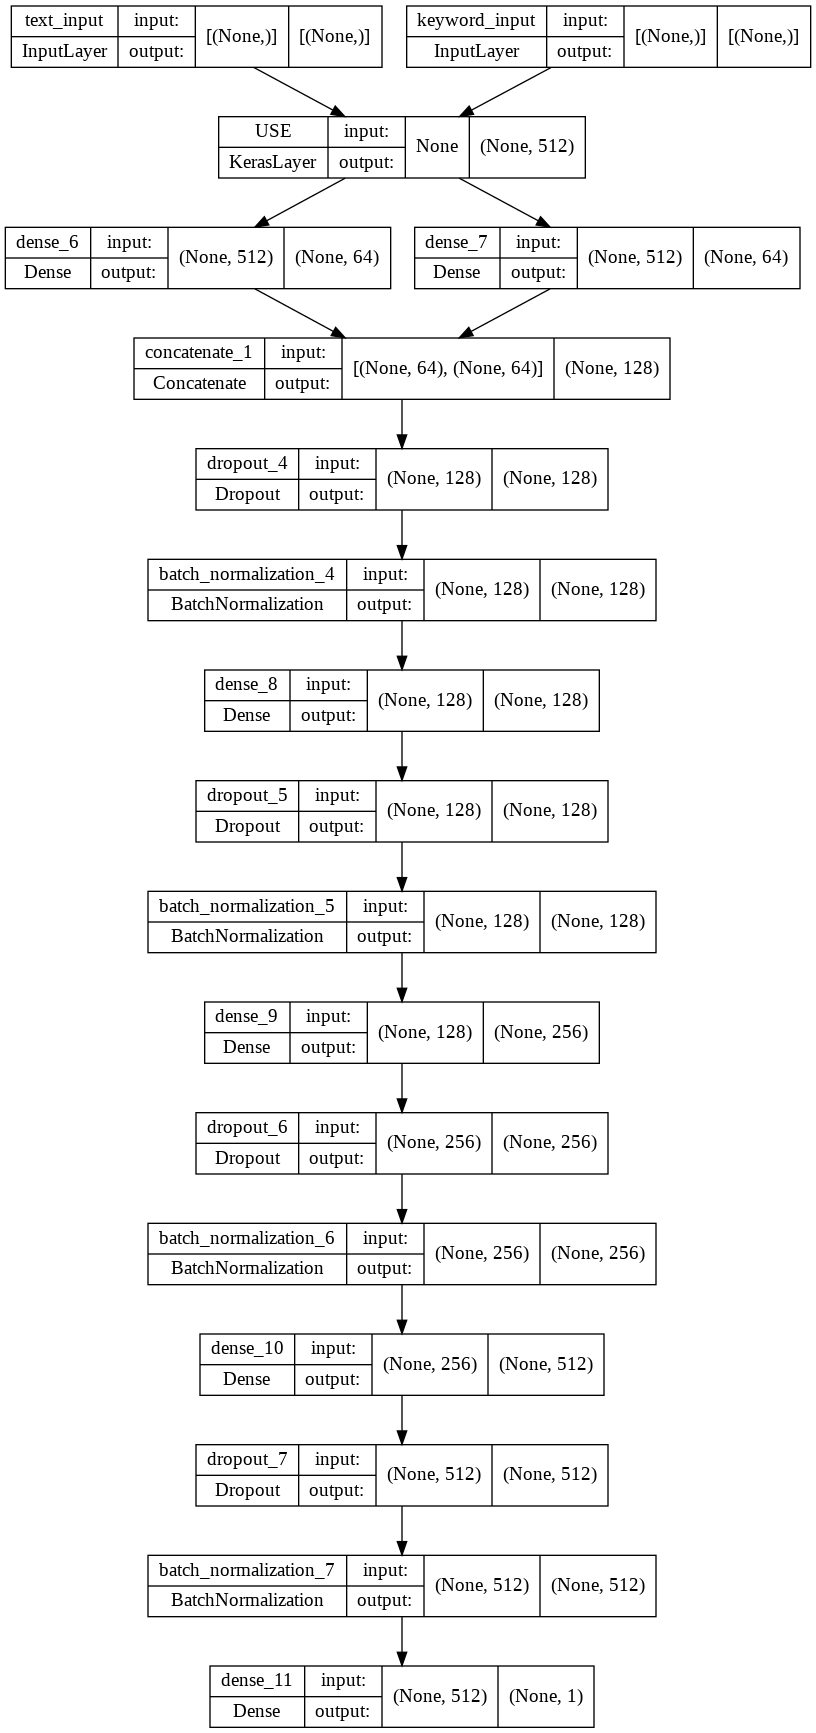

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(multi_model, show_shapes=True)

In [88]:
train_data = train.drop(columns=["target"], axis=1)
target = train["target"]

In [89]:
X_train, X_test, y_train, y_test = train_test_split(train_data, target, test_size=0.2, random_state=42)

In [90]:
train_text = X_train["text"]
train_keyword = X_train["keyword"]

test_text = X_test["text"]
test_keyword = X_test["keyword"]

In [91]:
train_text_data = tf.data.Dataset.from_tensor_slices(train_text)
train_keyword_data = tf.data.Dataset.from_tensor_slices(train_keyword)
train_target_data = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip(((train_text_data, train_keyword_data), train_target_data))
train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

test_text_data = tf.data.Dataset.from_tensor_slices(test_text)
test_keyword_data = tf.data.Dataset.from_tensor_slices(test_keyword)
test_target_data = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip(((test_text_data, test_keyword_data), test_target_data)) 
test_dataset = test_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

final_test_text_data = tf.data.Dataset.from_tensor_slices(test["text"])
final_test_keyword_data = tf.data.Dataset.from_tensor_slices(test["keyword"])
final_test_dataset = tf.data.Dataset.zip(((final_test_text_data, final_test_keyword_data),)) 
final_test_dataset = final_test_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

In [109]:
multi_history = multi_model.fit(train_dataset,
                epochs=100,
                steps_per_epoch = len(train_dataset),
                validation_data = test_dataset,
                validation_steps = len(test_dataset),
                callbacks = [create_model_checkpoint("multi")],
)

Saving model checkpoint to: tweets/multi
Epoch 1/100
95/96 [============================>.] - ETA: 0s - loss: 0.4609 - accuracy: 0.7928
Epoch 1: val_accuracy improved from -inf to 0.81287, saving model to tweets/multi
INFO:tensorflow:Assets written to: tweets/multi/assets


INFO:tensorflow:Assets written to: tweets/multi/assets


96/96 [==============================] - 14s 144ms/step - loss: 0.4608 - accuracy: 0.7927 - val_loss: 0.4175 - val_accuracy: 0.8129
Epoch 2/100
95/96 [============================>.] - ETA: 0s - loss: 0.4542 - accuracy: 0.7992
Epoch 2: val_accuracy improved from 0.81287 to 0.82206, saving model to tweets/multi
INFO:tensorflow:Assets written to: tweets/multi/assets


INFO:tensorflow:Assets written to: tweets/multi/assets


96/96 [==============================] - 13s 133ms/step - loss: 0.4542 - accuracy: 0.7993 - val_loss: 0.4142 - val_accuracy: 0.8221
Epoch 3/100
96/96 [==============================] - ETA: 0s - loss: 0.4620 - accuracy: 0.8006
Epoch 3: val_accuracy did not improve from 0.82206
96/96 [==============================] - 2s 22ms/step - loss: 0.4620 - accuracy: 0.8006 - val_loss: 0.4180 - val_accuracy: 0.8162
Epoch 4/100
93/96 [============================>.] - ETA: 0s - loss: 0.4465 - accuracy: 0.8017
Epoch 4: val_accuracy did not improve from 0.82206
96/96 [==============================] - 2s 21ms/step - loss: 0.4471 - accuracy: 0.8019 - val_loss: 0.4162 - val_accuracy: 0.8148
Epoch 5/100
95/96 [============================>.] - ETA: 0s - loss: 0.4462 - accuracy: 0.8043
Epoch 5: val_accuracy improved from 0.82206 to 0.82797, saving model to tweets/multi
INFO:tensorflow:Assets written to: tweets/multi/assets


INFO:tensorflow:Assets written to: tweets/multi/assets


96/96 [==============================] - 11s 120ms/step - loss: 0.4459 - accuracy: 0.8046 - val_loss: 0.4078 - val_accuracy: 0.8280
Epoch 6/100
95/96 [============================>.] - ETA: 0s - loss: 0.4466 - accuracy: 0.8125
Epoch 6: val_accuracy did not improve from 0.82797
96/96 [==============================] - 2s 22ms/step - loss: 0.4465 - accuracy: 0.8128 - val_loss: 0.4133 - val_accuracy: 0.8227
Epoch 7/100
96/96 [==============================] - ETA: 0s - loss: 0.4415 - accuracy: 0.8090
Epoch 7: val_accuracy did not improve from 0.82797
96/96 [==============================] - 2s 22ms/step - loss: 0.4415 - accuracy: 0.8090 - val_loss: 0.4105 - val_accuracy: 0.8227
Epoch 8/100
94/96 [============================>.] - ETA: 0s - loss: 0.4370 - accuracy: 0.8112
Epoch 8: val_accuracy did not improve from 0.82797
96/96 [==============================] - 2s 22ms/step - loss: 0.4367 - accuracy: 0.8111 - val_loss: 0.4114 - val_accuracy: 0.8227
Epoch 9/100
94/96 [=====================

INFO:tensorflow:Assets written to: tweets/multi/assets


96/96 [==============================] - 13s 138ms/step - loss: 0.4325 - accuracy: 0.8143 - val_loss: 0.4087 - val_accuracy: 0.8286
Epoch 10/100
94/96 [============================>.] - ETA: 0s - loss: 0.4308 - accuracy: 0.8122
Epoch 10: val_accuracy did not improve from 0.82863
96/96 [==============================] - 2s 22ms/step - loss: 0.4304 - accuracy: 0.8128 - val_loss: 0.4084 - val_accuracy: 0.8253
Epoch 11/100
96/96 [==============================] - ETA: 0s - loss: 0.4280 - accuracy: 0.8082
Epoch 11: val_accuracy did not improve from 0.82863
96/96 [==============================] - 2s 22ms/step - loss: 0.4280 - accuracy: 0.8082 - val_loss: 0.4068 - val_accuracy: 0.8214
Epoch 12/100
94/96 [============================>.] - ETA: 0s - loss: 0.4216 - accuracy: 0.8152
Epoch 12: val_accuracy did not improve from 0.82863
96/96 [==============================] - 2s 21ms/step - loss: 0.4214 - accuracy: 0.8151 - val_loss: 0.4064 - val_accuracy: 0.8214
Epoch 13/100
94/96 [==============

INFO:tensorflow:Assets written to: tweets/multi/assets


96/96 [==============================] - 11s 119ms/step - loss: 0.3954 - accuracy: 0.8289 - val_loss: 0.4033 - val_accuracy: 0.8293
Epoch 23/100
95/96 [============================>.] - ETA: 0s - loss: 0.4039 - accuracy: 0.8250
Epoch 23: val_accuracy did not improve from 0.82928
96/96 [==============================] - 2s 22ms/step - loss: 0.4036 - accuracy: 0.8251 - val_loss: 0.4051 - val_accuracy: 0.8201
Epoch 24/100
94/96 [============================>.] - ETA: 0s - loss: 0.3962 - accuracy: 0.8300
Epoch 24: val_accuracy did not improve from 0.82928
96/96 [==============================] - 2s 23ms/step - loss: 0.3958 - accuracy: 0.8297 - val_loss: 0.4055 - val_accuracy: 0.8221
Epoch 25/100
94/96 [============================>.] - ETA: 0s - loss: 0.4009 - accuracy: 0.8285
Epoch 25: val_accuracy did not improve from 0.82928
96/96 [==============================] - 2s 22ms/step - loss: 0.3999 - accuracy: 0.8292 - val_loss: 0.4053 - val_accuracy: 0.8201
Epoch 26/100
95/96 [==============

INFO:tensorflow:Assets written to: tweets/multi/assets


96/96 [==============================] - 12s 126ms/step - loss: 0.3850 - accuracy: 0.8353 - val_loss: 0.4070 - val_accuracy: 0.8352
Epoch 33/100
94/96 [============================>.] - ETA: 0s - loss: 0.3881 - accuracy: 0.8338
Epoch 33: val_accuracy did not improve from 0.83519
96/96 [==============================] - 2s 23ms/step - loss: 0.3874 - accuracy: 0.8343 - val_loss: 0.4058 - val_accuracy: 0.8267
Epoch 34/100
94/96 [============================>.] - ETA: 0s - loss: 0.3825 - accuracy: 0.8396
Epoch 34: val_accuracy did not improve from 0.83519
96/96 [==============================] - 2s 21ms/step - loss: 0.3818 - accuracy: 0.8399 - val_loss: 0.4068 - val_accuracy: 0.8240
Epoch 35/100
93/96 [============================>.] - ETA: 0s - loss: 0.3843 - accuracy: 0.8397
Epoch 35: val_accuracy did not improve from 0.83519
96/96 [==============================] - 2s 21ms/step - loss: 0.3830 - accuracy: 0.8399 - val_loss: 0.4076 - val_accuracy: 0.8260
Epoch 36/100
95/96 [==============

In [110]:
multi_model.evaluate(train_dataset), multi_model.evaluate(test_dataset)

24/24 [==============================] - 0s 15ms/step - loss: 0.4282 - accuracy: 0.8207


([0.2284156233072281, 0.9229758381843567],
 [0.42818939685821533, 0.820748507976532])

In [111]:
best_model = tf.keras.models.load_model("tweets/multi")
best_model.evaluate(test_dataset)

24/24 [==============================] - 1s 16ms/step - loss: 0.4070 - accuracy: 0.8352


[0.40698298811912537, 0.8351936936378479]

In [112]:
best_model.evaluate(train_dataset)

96/96 [==============================] - 1s 16ms/step - loss: 0.3124 - accuracy: 0.8744


[0.3124329149723053, 0.8743636012077332]

In [113]:
sub = get_submission_file(best_model, data=final_test_dataset)
sub

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,0


In [ ]:
text_input = tfl.Input(shape=[], dtype=tf.string, name="text_input")
text_embedding = sentence_encoder_layer(text_input)
text_x = tfl.Reshape((512, 1), input_shape=(512,))(text_embedding)
text_x = tfl.Bidirectional(tfl.LSTM(64))(text_x)

keyword_input = tfl.Input(shape=[], dtype=tf.string, name="keyword_input")
keyword_embedding = sentence_encoder_layer(keyword_input)
keyword_x = tfl.Dense(128, activation="relu")(keyword_embedding)
# keyword_x = tfl.Dropout(0.6)(keyword_x)

x = tfl.Concatenate()([text_x, keyword_x])
x = tfl.BatchNormalization()(x)

x = tfl.Dense(128, activation="relu")(x)
x = tfl.Dropout(0.7)(x)
x = tfl.BatchNormalization()(x)

x = tfl.Dense(256, activation="relu")(x)
x = tfl.Dropout(0.7)(x)
x = tfl.BatchNormalization()(x)

x = tfl.Dense(512, activation="relu")(x)
x = tfl.Dropout(0.8)(x)
x = tfl.BatchNormalization()(x)

output = tfl.Dense(1, activation="sigmoid")(x)

multi_model_2 = tf.keras.Model(inputs=[text_input, keyword_input], outputs=output, name="multi_model_2")
multi_model_2.compile(loss="binary_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])
        
multi_model_2.summary()

Model: "multi_model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['text_input[0][0]',             
                                                                  'keyword_input[0][0]']          
                                                                                                  
 keyword_input (InputLayer)     [(None,)]            0           []                               
                                                                                                  
 reshape_6 (Reshape)            (None, 512, 1)       0           ['USE[17][0]']       

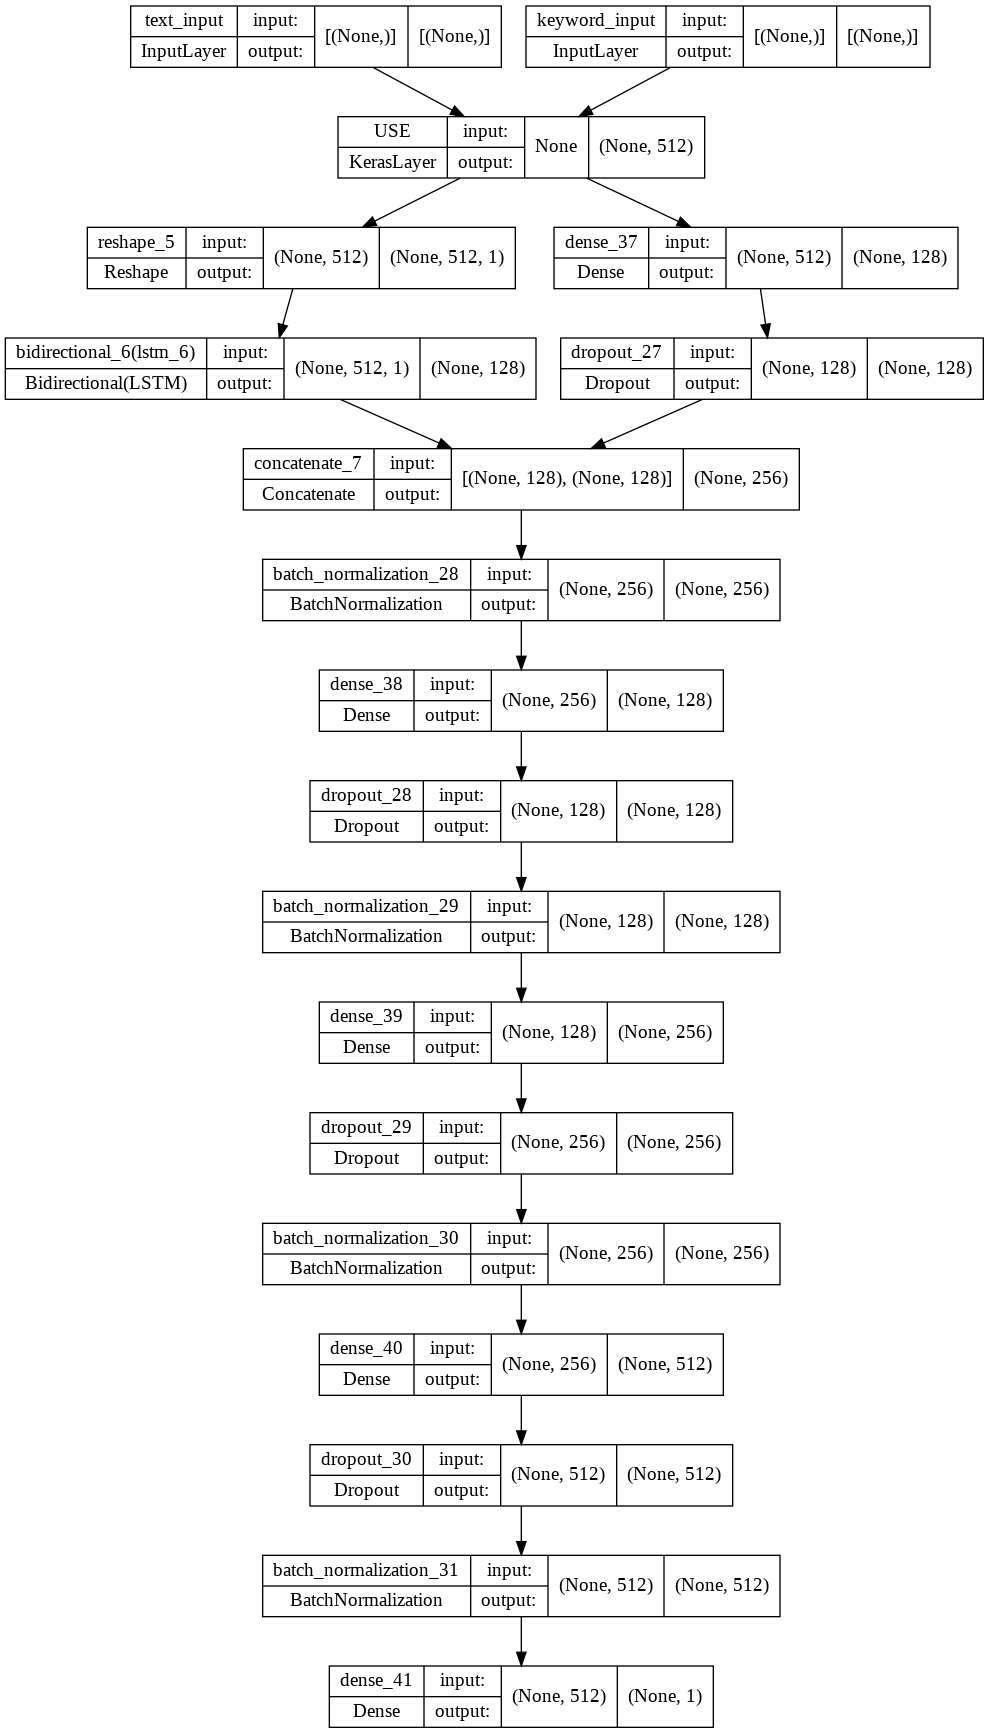

In [ ]:
plot_model(multi_model_2, show_shapes=True)

In [ ]:
multi_history_2 = multi_model_2.fit(train_dataset,
                epochs=50,
                steps_per_epoch = len(train_dataset),
                validation_data = test_dataset,
                validation_steps = len(test_dataset),
                # callbacks = [create_model_checkpoint("multi")],
)

Epoch 1/50
96/96 [==============================] - 6s 60ms/step - loss: 0.5575 - accuracy: 0.7318 - val_loss: 0.5543 - val_accuracy: 0.7177
Epoch 2/50
96/96 [==============================] - 6s 60ms/step - loss: 0.5513 - accuracy: 0.7356 - val_loss: 0.5618 - val_accuracy: 0.7144
Epoch 3/50
96/96 [==============================] - 6s 59ms/step - loss: 0.5472 - accuracy: 0.7346 - val_loss: 0.8495 - val_accuracy: 0.6047
Epoch 4/50
96/96 [==============================] - 6s 65ms/step - loss: 0.5452 - accuracy: 0.7369 - val_loss: 0.6124 - val_accuracy: 0.6973
Epoch 5/50
96/96 [==============================] - 6s 59ms/step - loss: 0.5417 - accuracy: 0.7425 - val_loss: 0.8525 - val_accuracy: 0.6021
Epoch 6/50
96/96 [==============================] - 6s 60ms/step - loss: 0.5419 - accuracy: 0.7413 - val_loss: 0.5778 - val_accuracy: 0.7137
Epoch 7/50
96/96 [==============================] - 6s 60ms/step - loss: 0.5306 - accuracy: 0.7505 - val_loss: 0.5410 - val_accuracy: 0.7301
Epoch 8/50
96

KeyboardInterrupt: ignored

### Using Character Level Encoding for `keyword`

In [ ]:
import tensorflow_hub as hub
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [13]:
train_keyword_char = list(train_keyword.apply(lambda x: " ".join(list(x))))
test_keyword_char = list(test_keyword.apply(lambda x: " ".join(list(x))))
final_test_keyword_char = list(test["keyword"].apply(lambda x: " ".join(list(x))))
train_keyword_char[0], final_test_keyword_char[0]

('m i l i t a r y', 'c r a s h')

In [14]:
char_lens = [len(x) for x in train_keyword_char]
max(char_lens), min(char_lens), np.mean(char_lens), np.percentile(char_lens, 95)


(41, 7, 16.224503202496305, 33.0)

In [15]:
vectorizer = tfl.TextVectorization(max_tokens=30,output_sequence_length=30, name="vectorizer")
vectorizer.adapt(train_keyword_char)

In [16]:
vocab = vectorizer.get_vocabulary()
len(vocab), vocab[:5]

(30, ['', '[UNK]', 'e', 'a', 'r'])

In [17]:
char_embed = tfl.Embedding(len(vocab), 32, name="char_embed")

In [79]:
text_input = tfl.Input(shape=[], dtype=tf.string, name="text_input")
text_embedding = sentence_encoder_layer(text_input)
text_x = tfl.Dense(32, activation="relu")(text_embedding)

keyword_input = tfl.Input(shape=[], dtype=tf.string, name="keyword_input")
keyword_vectorizer = vectorizer(keyword_input)
keyword_embedding = char_embed(keyword_vectorizer)
keyword_embedding = tfl.Reshape((3, 32*10))(keyword_embedding)
keyword_embedding = tfl.GlobalMaxPool1D()(keyword_embedding)
keyword_x = tfl.Dense(32, activation="relu")(keyword_embedding)

x = tfl.Concatenate()([text_x, keyword_x])
x = tfl.Dropout(0.8)(x)
x = tfl.BatchNormalization()(x)

# x = tfl.Dense(128, activation="relu")(x)
# x = tfl.Dropout(0.8)(x)
# x = tfl.BatchNormalization()(x)

# x = tfl.Dense(256, activation="relu")(x)
# x = tfl.Dropout(0.8)(x)
# x = tfl.BatchNormalization()(x)

# x = tfl.Dense(512, activation="relu")(x)
# x = tfl.Dropout(0.8)(x)
# x = tfl.BatchNormalization()(x)

output = tfl.Dense(1, activation="sigmoid")(x)

multi_model_2 = tf.keras.Model(inputs=[text_input, keyword_input], outputs=output)
multi_model_2.compile(loss="binary_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])
        
multi_model_2.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 keyword_input (InputLayer)     [(None,)]            0           []                               
                                                                                                  
 vectorizer (TextVectorization)  (None, 30)          0           ['keyword_input[0][0]']          
                                                                                                  
 char_embed (Embedding)         (None, 30, 32)       960         ['vectorizer[24][0]']            
                                                                                                  
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                           

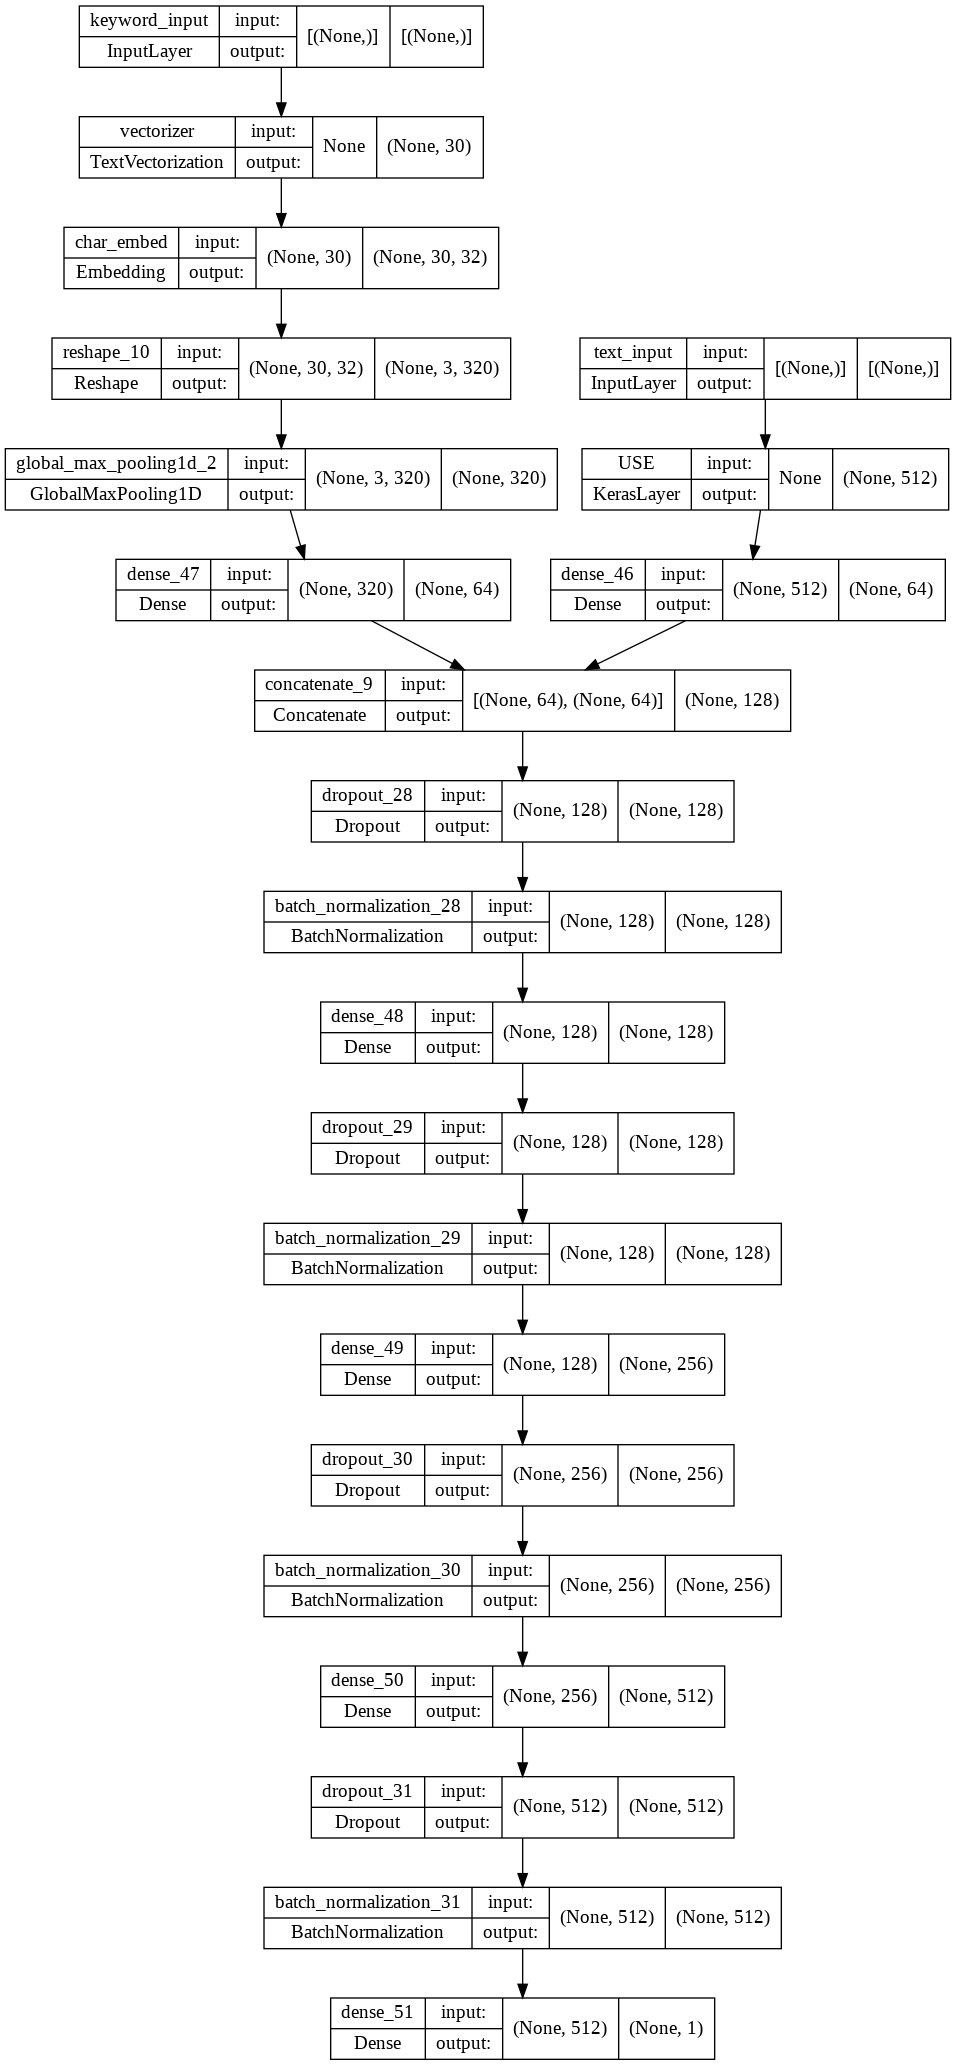

In [44]:
tf.keras.utils.plot_model(multi_model_2, show_shapes=True)

In [76]:
train_text_data = tf.data.Dataset.from_tensor_slices(train_text)
train_keyword_data = tf.data.Dataset.from_tensor_slices(train_keyword_char)
train_target_data = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip(((train_text_data, train_keyword_data), train_target_data))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_text_data = tf.data.Dataset.from_tensor_slices(test_text)
test_keyword_data = tf.data.Dataset.from_tensor_slices(test_keyword_char)
test_target_data = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip(((test_text_data, test_keyword_data), test_target_data)) 
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

final_test_text_data = tf.data.Dataset.from_tensor_slices(test["text"])
final_test_keyword_data = tf.data.Dataset.from_tensor_slices(final_test_keyword_char)
final_test_dataset = tf.data.Dataset.zip(((final_test_text_data, final_test_keyword_data),)) 
final_test_dataset = final_test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [81]:
history_multi_2 = multi_model_2.fit(train_dataset,
                epochs=20,
                steps_per_epoch = len(train_dataset),
                validation_data = test_dataset,
                validation_steps = len(test_dataset),
                callbacks = [create_model_checkpoint("multi")],
)

Saving model checkpoint to: tweets/multi
Epoch 1/20
191/191 [==============================] - ETA: 0s - loss: 0.4543 - accuracy: 0.7934
Epoch 1: val_accuracy improved from -inf to 0.82009, saving model to tweets/multi
INFO:tensorflow:Assets written to: tweets/multi/assets


INFO:tensorflow:Assets written to: tweets/multi/assets


191/191 [==============================] - 15s 76ms/step - loss: 0.4543 - accuracy: 0.7934 - val_loss: 0.4117 - val_accuracy: 0.8201
Epoch 2/20
187/191 [============================>.] - ETA: 0s - loss: 0.4505 - accuracy: 0.7961
Epoch 2: val_accuracy improved from 0.82009 to 0.82469, saving model to tweets/multi
INFO:tensorflow:Assets written to: tweets/multi/assets


INFO:tensorflow:Assets written to: tweets/multi/assets


191/191 [==============================] - 13s 70ms/step - loss: 0.4502 - accuracy: 0.7960 - val_loss: 0.4099 - val_accuracy: 0.8247
Epoch 3/20
189/191 [============================>.] - ETA: 0s - loss: 0.4544 - accuracy: 0.7955
Epoch 3: val_accuracy did not improve from 0.82469
191/191 [==============================] - 3s 14ms/step - loss: 0.4539 - accuracy: 0.7955 - val_loss: 0.4117 - val_accuracy: 0.8240
Epoch 4/20
187/191 [============================>.] - ETA: 0s - loss: 0.4489 - accuracy: 0.8006
Epoch 4: val_accuracy did not improve from 0.82469
191/191 [==============================] - 3s 14ms/step - loss: 0.4484 - accuracy: 0.8005 - val_loss: 0.4137 - val_accuracy: 0.8214
Epoch 5/20
188/191 [============================>.] - ETA: 0s - loss: 0.4468 - accuracy: 0.7972
Epoch 5: val_accuracy did not improve from 0.82469
191/191 [==============================] - 3s 14ms/step - loss: 0.4461 - accuracy: 0.7975 - val_loss: 0.4130 - val_accuracy: 0.8201
Epoch 6/20
191/191 [==========

In [82]:
multi_model_2.evaluate(train_dataset), multi_model_2.evaluate(test_dataset)

48/48 [==============================] - 0s 10ms/step - loss: 0.4119 - accuracy: 0.8207


([0.3424815833568573, 0.8551486134529114],
 [0.41191965341567993, 0.820748507976532])

In [83]:
best_model = tf.keras.models.load_model("tweets/multi")

In [84]:
best_model.evaluate(train_dataset), best_model.evaluate(test_dataset)

48/48 [==============================] - 0s 10ms/step - loss: 0.4099 - accuracy: 0.8247


([0.3666802644729614, 0.8410248160362244],
 [0.40988689661026, 0.8246881365776062])

In [85]:
sub = get_submission_file(best_model, data=final_test_dataset)
sub

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,0


In [86]:
sub["target"].value_counts()

0    2112
1    1151
Name: target, dtype: int64

This will be all for now.